# Straighten an image of a page User Interface

User Interface สำหรับการจับภาพหน้ากระดาษบนภาพและทำให้หน้ากระดาษตั้งตรง ซึ่งระบบจะตรวจหาขอบของรูปภาพ โดยใช้เทคนิค Adaptive Threshold และจะตรวจหาเส้นตรงบนภาพหลังจากหาขอบแล้ว โดยใช้เทคนิค hough line transform หลังจากนั้นจะหาจุดตัดของเส้นตรงที่ตั้งฉากกัน และกำหนดว่าจุดตัด 4 จุดที่ใกล้ขอบภาพที่สุดนั้นเป็นมุมของหน้ากระดาษ สุดท้ายก็ใช้มุมทั้ง 4 มุมนั้นเป็นจุด Keypoints ในการทำ Warp Perspective เพื่อให้หน้ากระดาษบนภาพตั้งตรง
โดยสาเหตุที่เลือกเทคนิคนี้มาจากการทดสองเปรียบเทียบจาก
https://colab.research.google.com/drive/1Xdo3SCUwQb4Joku7EJAtyoG96r7XHc-8?usp=sharing

## การใช้งาน
มี 3 ขั้นตอน

1. เลือกรูปภาพของกระดาษ โดยในภาพกระดาษจะต้องอยู่บนพื้นผิวที่ทำให้สังเกตกระดาษได้ง่าย ไม่มีเส้นตรงอื่นๆมารบกวนพื้นหลัง สามารถถ่ายรูปภาพที่กระดาษที่เอียงอยู่ และภาพกระดาษที่มีมุมโค้งมนได้
2. กดรันCode
3. แสดงผลลัพธ์ โดยถ้าผลลัพธ์ไม่เป็นตามต้องการสามารถลองปรับเปลี่ยนค่า minimun_vote ได้ โดยยิ่งภาพกระดาษที่ต้องการจับมีมาก ก็ควรปรับเลขให้มากตามไปด้วย

####References
1. ตัวอย่างการสร้างแบบฟอร์มเพื่อรับข้อมูลจาก Users ใน Colab ดูได้ที่
https://colab.research.google.com/notebooks/forms.ipynb
2. ตัวอย่างการอัพโหลดภาพจาก Local File System
https://colab.research.google.com/notebooks/snippets/accessing_files.ipynb
3. วิธีการใช้เทคนิค hough line transform และจะจุดที่intersecกันของเส้นตรง
https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv
4. วิธีการใช้เทคนิคในการทำ Warp Perspective 
https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
5.วิธีในการทำ adaptiveThreshold 
https://codesearchonline.com/opencv-document-scanner-python/

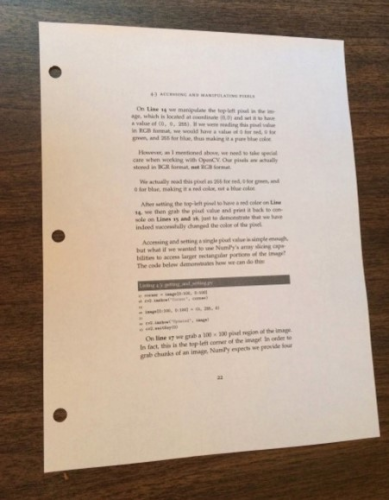

In [ ]:
#@markdown <h3> 🖼️ เลือกรูปภาพ Choose An Image</h3>
#@markdown <small>สามารถเลือกภาพตัวอย่างหรือจะอัพโหลดภาพของคุณ Pick the preset image or upload your own image</small>
import numpy as np
import cv2
from collections import defaultdict
import os
import imutils
import sys
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import HTML

image = '\uD83D\uDDCF page' #@param ['🗏 page', '🧾 receipt', '📤 upload your image']

image = ' '.join(image.split(' ')[1:])
onedrive_dataset = None

image_url = {
  'page': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/EYrbOpH-4KxKh92HODIIu14BtZ-2t7tPW2BAqpK9cpCPwA?download=1',
  'receipt': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/Eas6Z4A_v0JBr8r-AEgh8VQBeOoOWC2tdZtEPc_CJ3RPNw?download=1',
}

if image == 'upload your image': onedrive_dataset = ':images_upload:'
elif image in image_url:  onedrive_dataset = image_url[image]
if onedrive_dataset == None: raise Exception('Cannot select image')

preupload_datasets = None
if onedrive_dataset == ':images_upload:':
  display(HTML('<h3>Select your image</h3>'))
  # display(HTML('<p/>You can select multiple images by pressing ctrl, cmd or shift and click.<p>'))
  dir = os.getcwd()
  uploaded = files.upload()
  preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
  image_fn = preupload_datasets[0]
else:
  get_ipython().system_raw('wget -O image.jpg ' + onedrive_dataset)
  image_fn = 'image.jpg'

im = cv2.imread(image_fn)
im = imutils.resize(im,height=500)
cv2_imshow(im)

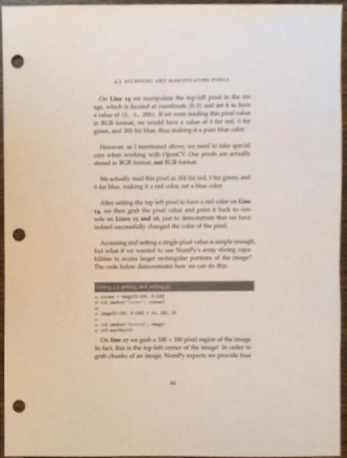

In [ ]:
#@markdown <h3> 🔮 แสดง  Straighten image ของภาพหน้ากระดาษ</h3>

#@markdown <small>สามารถลองปรับเปลี่ยนค่า minimun_vote ได้ โดยยิ่งภาพกระดาษที่ต้องการจับมีมาก ก็ควรปรับเลขให้มากตามไปด้วย แต่ถ้าภาพกระดาษเล็กเกินไปลองปรับภาพให้น้อยลง </small>


#เปลี่ยนภาพ RGB เป็น Grayscale และ Blurภาพเพื่อลดnoise
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

#หาขอบของภาพด้วยAdaptive Threshold
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)

#ฟังก์ชั่นในการแบ่งเส้นตรงเป็น2ประเภทที่ตั้งฉากกัน
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """
    Group lines by their angle using k-means clustering.

    Code from here:
    https://stackoverflow.com/a/46572063/1755401
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))

    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # Get angles in [0, pi] radians
    angles = np.array([line[0][1] for line in lines])

    # Multiply the angles by two and find coordinates of that angle on the Unit Circle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)] for angle in angles], dtype=np.float32)

    # Run k-means
    if sys.version_info[0] == 2:
        # python 2.x
        ret, labels, centers = cv2.kmeans(pts, k, criteria, attempts, flags)
    else: 
        # python 3.x, syntax has changed.
        labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]

    labels = labels.reshape(-1) # Transpose to row vector

    # Segment lines based on their label of 0 or 1
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)

    segmented = list(segmented.values())

    return segmented

#ฟังก์ชั่นในการหาจุดที่intersecกัน
def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]

#ฟังก์ชั่นหาจุดintersecของเส้นที่ตั้งฉากกัน
def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

#หาเส้นจากเทคนิค hough line transform และเอาจุดของเส้นที่ตั้งฉากกัน
def intersection_point(im,edged_image,vote):
  lines = cv2.HoughLines(edged_image, 2, np.pi/180, vote)
  if sys.version_info[0] == 2:
      # python 2.x
      temp_lines = []
      N = lines.shape[1]
       # Re-shape from 1xNx2 to Nx1x2
      for i in range(N):
        rho = lines[0,i,0]
        theta = lines[0,i,1]
        temp_lines.append( np.array([[rho,theta]]) )
      lines = temp_lines
  segmented = segment_by_angle_kmeans(lines, 2)
  intersections = segmented_intersections(segmented)
  coord=np.array(intersections).reshape(len(intersections),2)
  coord_point=[]
  for x,y in coord:
    if x>0 and y>0:
      coord_point.append([x,y])
  return coord_point

#เลือกจุดที่อยู่ใกล้ขอบของภาพมากที่สุด
def corner_houghlines(im,edged_image,vote):
  point=intersection_point(im,edged_image,vote)
  
  h, w = edged_image.shape
  tl = np.array((0,0))
  tr = np.array((0,w))
  bl = np.array((h,0))
  br = np.array((h,w))
  
  corners = []
  for pnt in [tl, tr, br, bl]:
    ((point - pnt)**2).sum(axis=1).argmin()
    pos = ((point - pnt)**2).sum(axis=1).argmin()
    corners.append(point[pos])
  return corners

#เรียงลำดับของจุดมุมใหม่
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
 
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	pts_del = np.delete(pts,[np.argmin(s),np.argmax(s)],0)
	diff = np.diff(pts_del, axis = 1)
	rect[1] = pts_del[np.argmin(diff)]
	rect[3] = pts_del[np.argmax(diff)]

	return rect

#หาความกว้างและยาวของสี่เหลี่ยมที่ตั้งตรง และเขียนเงื่อนไขที่ทำให้ภาพที่เฉียงอยู่ตั้งตรง 
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	corner=np.array((tl,tr,br,bl))
	if maxWidth<=maxHeight:
		 a=maxWidth
		 b=maxHeight
	else:
		a=maxHeight
		b=maxWidth
		if tl[1]<tr[1]:
			corner=np.array((bl,tl,tr,br))
		elif tl[1]>tr[1]:
			 corner=np.array((tr,br,bl,tl))	 
	dst = np.array([
		[0, 0],
		[a - 1, 0],
		[a - 1, b - 1],
		[0, b - 1]], dtype = "float32") 
	M = cv2.getPerspectiveTransform(corner, dst)
	warped = cv2.warpPerspective(image, M, (a, b))

	return warped

warped_houghlines = four_point_transform(im, np.array(corner_houghlines(im,adaptive_thresh,minimun_vote)))
cv2_imshow(warped_houghlines)